This file will be to make figure 1 or the triangle plot from Sen 2015. We need to do the following steps to produce this plot:
1. Select systems of interest - in our case these are binary white dwarfs
2. Select the masses of these systems were M1>M2
3. Make a skeleton plot of the triangle plot but setting mass and stellar type bounds
4. Make a 2D histogram or density plot the includes redshift information (at a sepcific redshift or over all redshifts)

### 1. Selecting Systems of Interest

In [1]:
# let's import things
import h5py as h5 
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text.latex', preamble=r'\usepackage{textgreek}')
plt.rc('font', family='serif')
import sys
import os

# Add the subdir to sys.path
sys.path.append('/home/jovyan/home/research_work/useful_py_scripts/')

# Now you can import the module
import useful_fncs 

In [2]:
# now let's make a bool or use numpy.isin to select for BWDs
# let's test out how it works with random arrays
# first let's make a random list
test_list = np.array([3, 11, 10, 4, 5])
# let's specify the criteria we want to identify in the list (similar to how we want to select a certain stellar type from a list)
criteria_match = [10,11]

# creating the mask and specifying which elements of the list agree or do not agree with the criteria
mask = np.isin(test_list, criteria_match)

# selecting only the elements that agree
test_list[mask]

array([11, 10])

In [3]:
# reading in the HDF5 file
pathToweights_H5 = '/home/jovyan/home/copy_h5_files/v03.08.01/COMPAS_Output_wWeights_fbin07.h5'  #path of the hdf5 file

Data_weights = h5.File(pathToweights_H5,"r")

# let's gather the system parameters group 
SP_WD_data = pd.DataFrame() # making a pandas dataframe

for key in Data_weights["BSE_Double_Compact_Objects"].keys(): #looping through the "keys" or paramters in BSE_System_Parameters

    SP_WD_data[key] = Data_weights["BSE_Double_Compact_Objects"][key][()] # adding these columns to the dataframe

# Rates info directly taking out the 
merger_SEED = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['SEED'][()]
rates_WDWD = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate'][()]
rates_z0_WDWD = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate_z0'][()]
DCO_mask = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]
redshifts = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['redshifts'][()]
# rates_info = Data_weights["Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048"]

Data_weights.close()

In [5]:
# let's try selecting all systems with white dwarfs now using the np.isin technique

# WDWD_mask = np.logical_and(np.isin(SP_WD_data['Stellar_Type(1)'],[10,11,12]),np.isin(SP_WD_data['Stellar_Type(2)'],[10,11,12]))
SP_WDWD_DATA = SP_WD_data[DCO_mask]

### 2. Select the Masses of these Systems

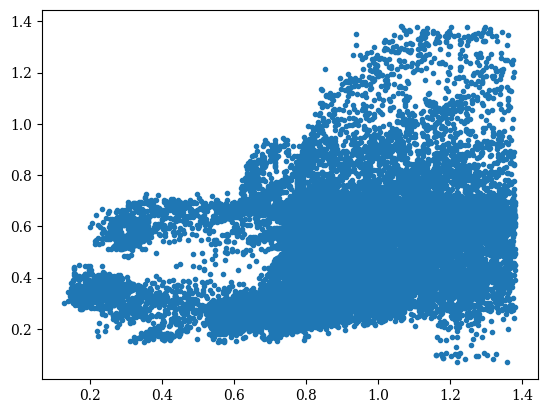

In [6]:
Mass1 = np.array(SP_WDWD_DATA['Mass(1)'])
Mass2 = np.array(SP_WDWD_DATA['Mass(2)'])
plt.plot(Mass1, Mass2, '.')

### 3. Make a Skeleton Plot

In [8]:
M1 = np.maximum(Mass1,Mass2)
M2 = np.minimum(Mass1, Mass2)
# # we need to make sure that we are only selecting for M1 that is larger than M2, this is only needed if we are not dealing with a datatframe
# M1 = []
# M2 = []
# for i in range(len(Mass1)):
#     if Mass1[i]>Mass2[i]:
#         M1.append(Mass1[i])
#     if Mass2[i]<Mass1[i]:
#         M2.append(Mass2[i])

In [9]:
print(np.shape(SP_WDWD_DATA))
print(np.shape(M1))
print(np.shape(M2))

(37517, 24)
(37517,)
(37517,)


Text(0, 0.5, '$M_{2}/M_{\\odot}$')

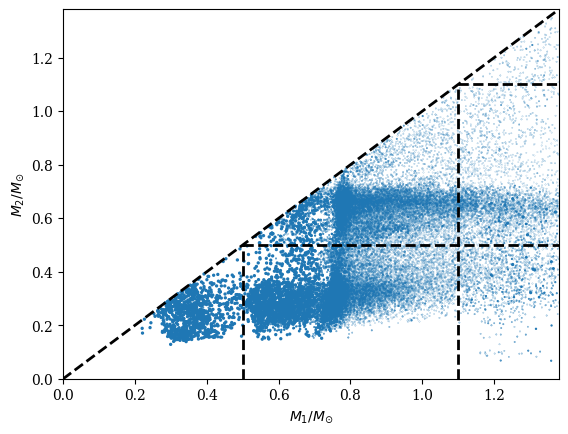

In [10]:
# let's plot the masses
plt.scatter(M1,M2,s=SP_WDWD_DATA['mixture_weight'])

# let's add the restrictive lines to the plot
# there should be no plots in the upper left triangle because M1>M2

plt.axline((0,0), (max(M1),max(M1)), color="black", ls='--', lw = 2, transform=plt.gca().transAxes)

xlim = max(M1)
ylim = max(M1)

# let's add the mass restrictions for each case of BWD
#Helium WD cutoff
plt.vlines(x=[0.5], ymin=0, ymax=0.5, colors='black', ls='--', lw=2)
plt.axhline(y=0.5, color='black', xmin = 0.5/xlim, xmax = max(M1)/xlim, ls='--', lw=2) # for axhline, the xmin and mxmax are scale factors of the axis not positions
#Carbon oxygen WD cutoff
plt.vlines(x=[1.1], ymin=0, ymax=1.1, colors='black', ls='--', lw=2)
plt.axhline(y=1.1, color='black', xmin = 1.1/xlim, xmax = max(M1)/xlim, ls='--', lw=2)


# setting the limits of the plot
plt.xlim(0,xlim)
plt.ylim(0,ylim)

# axes labels
plt.xlabel("$M_{1}/M_{\odot}$")
plt.ylabel("$M_{2}/M_{\odot}$")

### 4. Make a Density plot

In [16]:
# before making the density plot we need to gather the merger rate for these systems at every redshift
# Rates info for Z = 0
WDWD_merger_rate_Z0 = rates_z0_WDWD

#### Tom Wagg KDE Method

In [14]:
## Used from Tom Wagg's LEGWORK Visualization code

from astropy.visualization import quantity_support
import seaborn as sns

def plot_2D_dist(x, y, weights=None, disttype="scatter", fig=None, ax=None, show=True, figsize=(12, 7),
                 xlabel=None, ylabel=None, xlim=None, ylim=None, log_scale=False,
                 color=None, scatter_s=20, **kwargs):
    """Plot a 2D distribution of `x` and `y`

    This function is a wrapper for :func:`matplotlib.pyplot.scatter` and :func:`seaborn.kdeplot`.

    Parameters
    ----------
    x : `float/int array`
        Variable to plot on the x axis, should be a 1D array

    y : `float/int array`
        Variable to plot on the y axis, should be a 1D array

    weights : `float/int array`
        Weights for each variable pair (``x``, ``y``), must have the same shape

    disttype : `{{ "scatter", "kde" }}`
        Which type of distribution plot to use

    fig: `matplotlib Figure`
        A figure on which to plot the distribution. Both `ax` and `fig` must be supplied for either to be used

    ax: `matplotlib Axis`
        An axis on which to plot the distribution. Both `ax` and `fig` must be supplied for either to be used

    show : `boolean`
        Whether to immediately show the plot or only return the Figure and Axis

    figsize : `tuple`
        Tuple with size for the x- and y-axis if creating a new figure (i.e. ignored when fig/ax is not None)

    xlabel : `string`
        Label for the x axis, passed to Axes.set_xlabel()

    ylabel : `string`
        Label for the y axis, passed to Axes.set_ylabel()

    xlim : `tuple`
        Lower and upper limits for the x axis, passed to Axes.set_xlim()

    ylim : `tuple`
        Lower and upper limits for the u axis, passed to Axes.set_ylim()

    log_scale : `bool or tuple of bools`
        Whether to use a log scale for the axes. A single `bool` is applied to both axes, a tuple is applied
        to the x- and y-axis respectively.

    scatter_s : `float`, default=20
        Scatter point size, passed as ``s`` to a scatter plot and ignored for a KDE

    color : `string or tuple`
        Colour to use for the plot, see https://matplotlib.org/tutorials/colors/colors.html for details on how
        to specify a colour

    **kwargs : `(if disttype=="scatter")`
        Input any of `s, c, marker, cmap, norm, vmin, vmax, alpha, linewidths, edgecolors` or more.
        See :func:`matplotlib.pyplot.scatter` for more details.

    **kwargs : `(if disttype=="kde")`
        Input any of `gridsize, cut, clip, legend, cumulative, cbar, cbar_ax, cbar_kws, bw_method, hue,
        palette, hue_order, hue_norm, levels, thresh, bw_adjust, log_scale, fill, label`.
        See :func:`seaborn.kdeplot` for more details.

    Returns
    -------
    fig : `matplotlib Figure`
        The figure on which the distribution is plotted

    ax : `matplotlib Axis`
        The axis on which the distribution is plotted
    """
    # create new figure and axes is either weren't provided
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # expand log_scale
    if isinstance(log_scale, bool):
        log_scale = (log_scale, log_scale)

    # change default kwargs for matplotlib.scatter
    scatter_args = {}

    # possible kwargs for seaborn.kdeplot
    kde_args = {"gridsize": 200, "legend": True, "levels": 10, "thresh": 0.02}

    # set which ones we are using for this plot
    plot_args = scatter_args if disttype == "scatter" else kde_args

    # update the values with those supplied
    for key, value in kwargs.items():
        plot_args[key] = value

    # create whichever plot was requested
    with quantity_support():
        if disttype == "scatter":
            # change the size of scatter points based on their weights
            if weights is not None:
                scatter_s = weights * scatter_s

            ax.scatter(x, y, s=scatter_s, color=color, **plot_args)

            # apply log scaling to the respective axes
            if log_scale[0]:
                ax.set_xscale("log")
            if log_scale[1]:
                ax.set_yscale("log")
        elif disttype == "kde":
            sns.kdeplot(x=x, y=y, weights=weights, ax=ax, color=color, log_scale=log_scale, **plot_args)

    # update axis labels
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    # update axis limits
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # immediately show the plot if requested
    if show:
        plt.show()

    # return the figure and axis for further plotting
    return fig, ax


In [ ]:
# define the detectable parameters
cutoff = 0
detectable_snr = sources.snr[sources.snr > cutoff]
norm = TwoSlopeNorm(vmin=np.log10(np.min(detectable_snr)),
                    vcenter=0, vmax=np.log10(np.max(detectable_snr)))

fig, ax = sources.plot_sources_on_sc(snr_cutoff=cutoff, marker="*", cmap="PuOr_r",
                                     c=np.log10(detectable_snr), show=False, norm=norm, scatter_s=50)

# create a colorbar from the scatter points
cbar = fig.colorbar(ax.collections[1])
cbar.ax.set_ylabel(r"$\log_{10} (\rho)$")

plt.show()

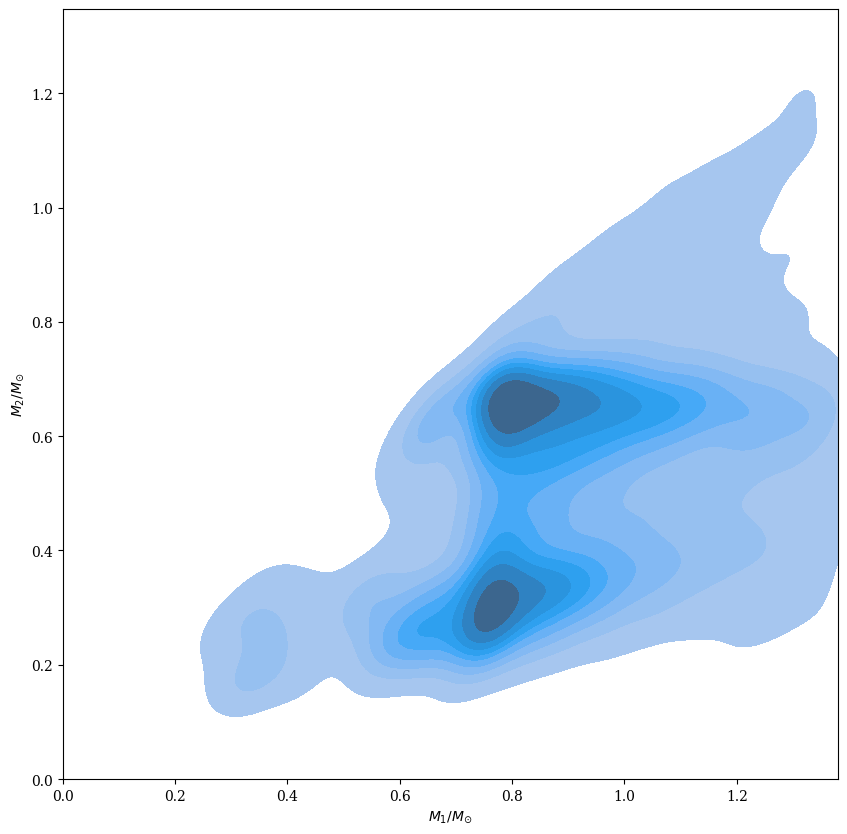

In [29]:
# creating a figure
fig, ax = plt.subplots(figsize=(10, 10))

# add the scatter plot
fig, ax = plot_2D_dist(x=M1, y=M2, fig=fig, ax=ax, disttype="kde", fill=True, xlim=(0, max(M1)), ylim=(0, max(M2)),
                           xlabel="$M_{1}/M_{\odot}$", ylabel="$M_{2}/M_{\odot}$")


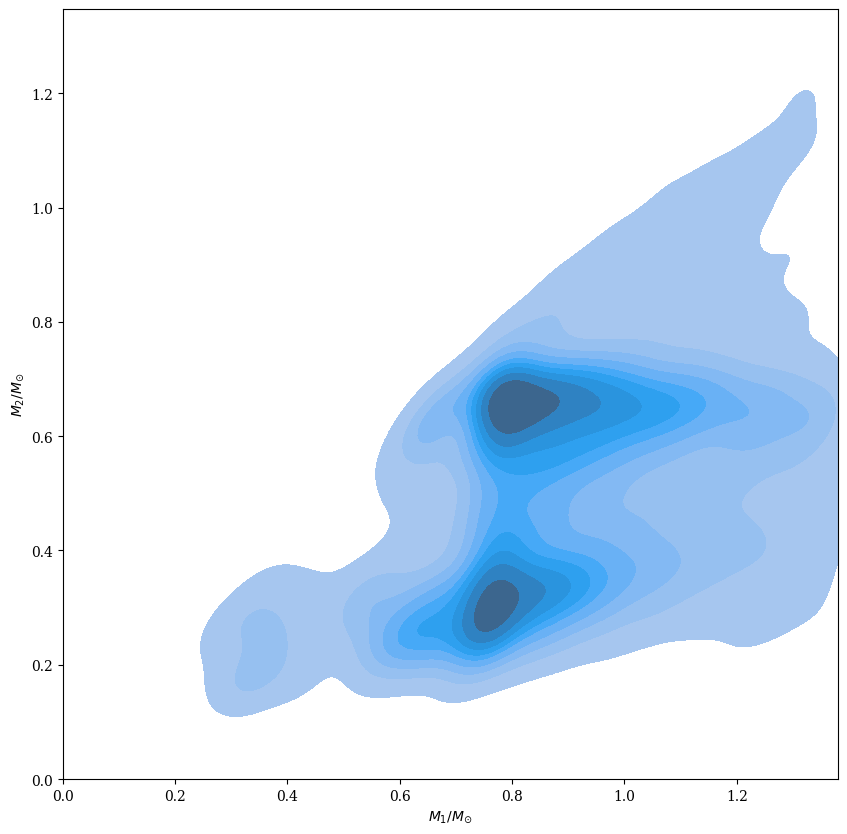

In [42]:
# for the 2D histogram or heatmap, we must consider the rates for each system plotted above

# # let's first define an array of rates 
# rates_systems = np.random.rand(len(M1))#make some numbers up for now until we actually comput the rates 

# let's define what we want to plot and the rates associated with each system 
# cm = plt.cm.get_cmap('RdYlBu')
# sc = plt.scatter(M1, M2, s=rates_z0_WDWD, cmap=cm)

# plt.colorbar(sc, label="Merger Rate [$\mathrm{dNdGpc^{-3}dyr^{-1}}$]")

fig, ax = plt.subplots(figsize=(10, 10))

# add the scatter plot
fig, ax = plot_2D_dist(x=M1, y=M2, fig=fig, ax=ax, disttype="kde", fill=True, xlim=(0, max(M1)), ylim=(0, max(M2)),
                           xlabel="$M_{1}/M_{\odot}$", ylabel="$M_{2}/M_{\odot}$")

# let's add the restrictive lines to the plot
# there should be no plots in the upper left triangle because M1>M2

# ax.axline((0,0), (1.3,1.3), color="black", ls='--', lw = 2, transform=fig.gca().transAxes)

# xlim = 1.3
# ylim = 1.3

# # let's add the mass restrictions for each case of BWD
# #Helium WD cutoff
ax.axvline(x=[0.5], ymin=0, ymax=0.5, color='black', lw=2)
# ax.axhline(y=0.5, color='black', xmin = 0.5/xlim, xmax = 1.3/xlim, ls='--', lw=2) # for axhline, the xmin and mxmax are scale factors of the axis not positions
# #Carbon oxygen WD cutoff
# ax.vlines(x=[1.1], ymin=0, ymax=1.1, colors='black', ls='--', lw=2)
# ax.axhline(y=1.1, color='black', xmin = 1.1/xlim, xmax = 1.3/xlim, ls='--', lw=2)


# # setting the limits of the plot
# ax.xlim(0,xlim)
# ax.ylim(0,ylim)

# # axes labels
# ax.xlabel("$M_{1}/M_{\odot}$")
# ax.ylabel("$M_{2}/M_{\odot}$")

#### Hexagonal Binned Method

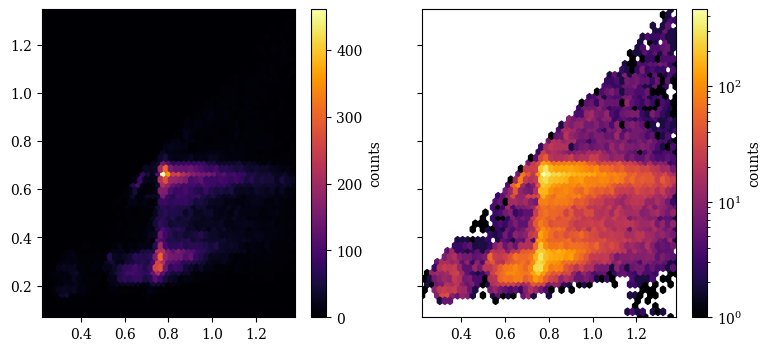

In [45]:
# below is the hexagonal binned method
import matplotlib.pyplot as plt
import numpy as np

fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(9, 4))

xlim = M1.min(), M1.max()
ylim = M2.min(), M2.max()

hb = ax0.hexbin(M1, M2, gridsize=50, cmap='inferno')
ax0.set(xlim=xlim, ylim=ylim)
# ax0.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax0, label='counts')

hb = ax1.hexbin(M1, M2, gridsize=50, bins='log', cmap='inferno')
ax1.set(xlim=xlim, ylim=ylim)
# ax1.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax1, label='counts')

plt.show()

Text(0, 0.5, '$M_{2}/M_{\\odot}$')

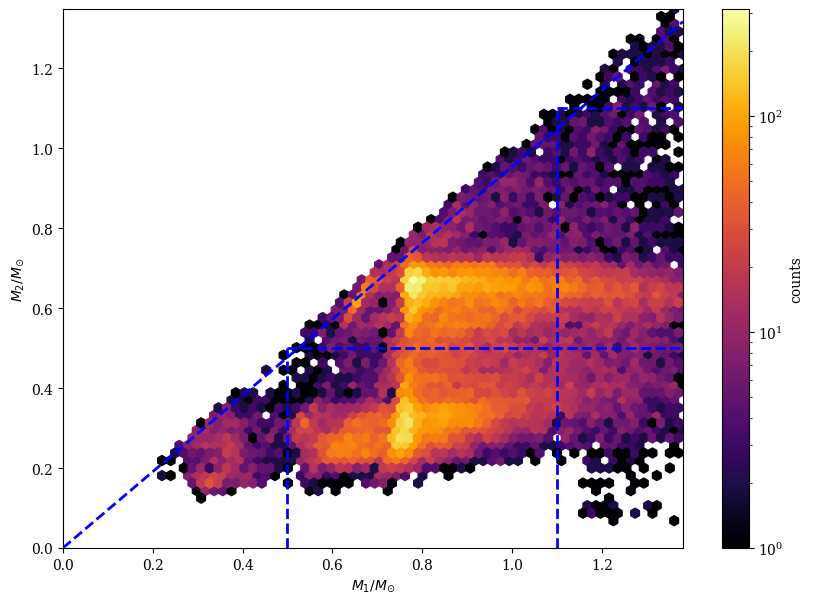

In [74]:
# below is the hexagonal binned method
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(10, 7))

xlim = M1.min(), M1.max()
ylim = M2.min(), M2.max()


# hb = ax1.hexbin(M1, M2, gridsize=60, bins='log', cmap='inferno')
hb = ax1.hexbin(M1, M2, gridsize=60, bins='log',cmap='inferno')
ax1.set(xlim=xlim, ylim=ylim)
# ax1.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax1, label='counts')

xscale = max(M1)
yscale = max(M2)

# let's add the mass restrictions for each case of BWD

plt.axline((0,0), (xscale,yscale), color="blue", ls='--', lw = 2, transform=plt.gca().transAxes)

#Helium WD cutoff
plt.vlines(x=0.5, ymin=0, ymax=0.5, colors='blue', ls='--', lw=2)
plt.axhline(y=0.5, color='blue', xmin = 0.5/xscale, xmax = xscale/xscale, ls='--', lw=2) # for axhline, the xmin and mxmax are scale factors of the axis not positions
#Carbon oxygen WD cutoff
plt.vlines(x=1.1, ymin=0, ymax=1.1, colors='blue', ls='--', lw=2)
plt.axhline(y=1.1, color='blue', xmin = 1.1/xscale, xmax = xscale/xscale, ls='--', lw=2)


# setting the limits of the plot
ax1.set_xlim(0,xscale)
ax1.set_ylim(0,yscale)

# axes labels
ax1.set_xlabel("$M_{1}/M_{\odot}$")
ax1.set_ylabel("$M_{2}/M_{\odot}$")


#### My own method

/tmp/ipykernel_174323/1330682747.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


Text(0, 0.5, '$M_{2}/M_{\\odot}$')

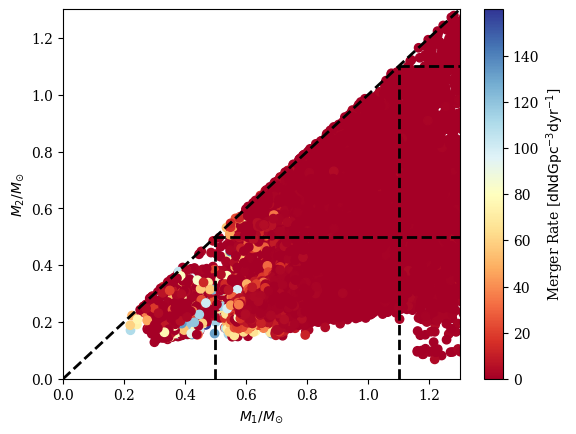

In [68]:
# for the 2D histogram or heatmap, we must consider the rates for each system plotted above

# # let's first define an array of rates 
# rates_systems = np.random.rand(len(M1))#make some numbers up for now until we actually comput the rates 

# let's define what we want to plot and the rates associated with each system 
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(M1, M2, c=rates_z0_WDWD, cmap=cm)

plt.colorbar(sc, label="Merger Rate [$\mathrm{dNdGpc^{-3}dyr^{-1}}$]")

# let's add the restrictive lines to the plot
# there should be no plots in the upper left triangle because M1>M2
xlim = 1.3
ylim = 1.3

plt.axline((0,0), (xlim,ylim), color="black", ls='--', lw = 2, transform=plt.gca().transAxes)


# let's add the mass restrictions for each case of BWD
#Helium WD cutoff
plt.vlines(x=[0.5], ymin=0, ymax=0.5, colors='black', ls='--', lw=2)
plt.axhline(y=0.5, color='black', xmin = 0.5/xlim, xmax = 1.3/xlim, ls='--', lw=2) # for axhline, the xmin and mxmax are scale factors of the axis not positions
#Carbon oxygen WD cutoff
plt.vlines(x=[1.1], ymin=0, ymax=1.1, colors='black', ls='--', lw=2)
plt.axhline(y=1.1, color='black', xmin = 1.1/xlim, xmax = 1.3/xlim, ls='--', lw=2)


# setting the limits of the plot
plt.xlim(0,xlim)
plt.ylim(0,ylim)

# axes labels
plt.xlabel("$M_{1}/M_{\odot}$")
plt.ylabel("$M_{2}/M_{\odot}$")